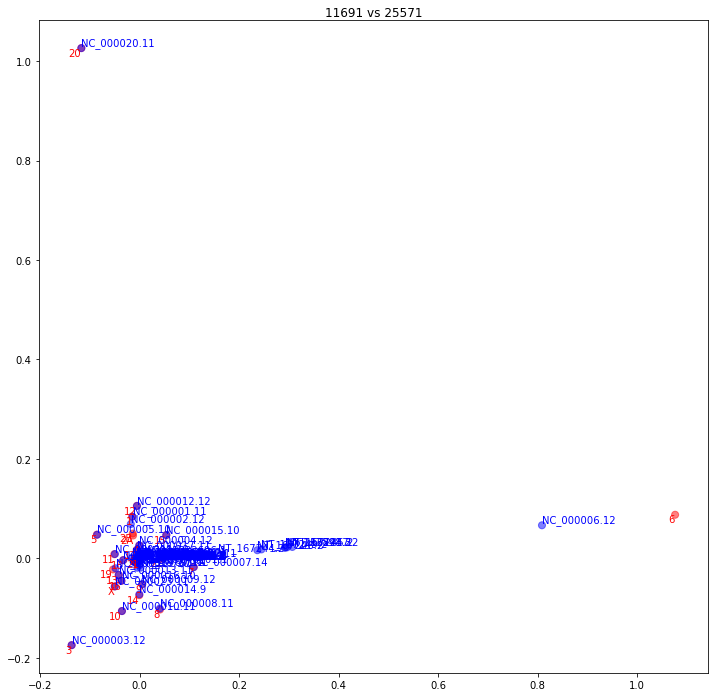

In [8]:
from glob import glob
import json
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

%matplotlib inline
import mpld3
mpld3.enable_notebook()

from kernel import kernel2
from clean import cleanChr
np.set_printoptions(precision=4)

gids = ['11691', '25571']#,'7057','28918','4242','28814']
meta = {}
chrNames = [0,0]
for j,gid in enumerate(gids):
    with open('ks/meta/'+gid) as meta_file:    
        meta[gid] = json.load(meta_file)
        chrNames[j] = [i['name'] for i in meta[gid]['chromosomes']]
##cleanChr(gids[0],gids[1])

chrNamesComb = chrNames[0] + chrNames[1]
K = pd.DataFrame(
        data = np.eye(len(chrNamesComb)), 
        index = chrNamesComb, 
        columns = chrNamesComb)

#build K, the chr ks matrix, each entry is a dot product
#measure of a chromosome pair
for fpath in glob('ks/cleanChrTmp/*.*'):
    s = fpath.split('/')[-1].split('|')
    gid1 = s[0].split('_')[0]
    gid2 = s[1].split('_')[0]
    #print gid1, gid2
    chr1 = s[0].split('_')[-1]
    chr2 = s[1].split('_')[1:]
    chr2 = '_'.join(chr2)
    #print chr1, chr2
    df = pd.read_csv(fpath,
                    header = None,
                    sep = '\t',
                    )
    
    n1 = filter(lambda o: o['name']==chr1, meta[gid1]['chromosomes'])
    n2 = filter(lambda o: o['name']==chr2, meta[gid2]['chromosomes'])
    #print n1,n2
    n1 = n1[0]['gene_count'] if len(n1)>0 else (  len(set(df[1])) or 1  )
    n2 = n2[0]['gene_count'] if len(n2)>0 else (  len(set(df[2])) or 1  )
    #print n1,n2
    k = kernel2(df, 1, n1, n2)
    K[chr1][chr2] = k
    K[chr2][chr1] = k

pca = PCA(n_components = 3)
pca.fit(K)
x = pca.transform(K)
colors = ['r' if c in chrNames[0] else 'b' for c in K.index] 

plt.figure(figsize=(12,12))
plt.scatter(x[:,0],x[:,1],c=colors, alpha = 0.5, s=50)
plt.axis('equal')

for i,d in enumerate(K.index):
    if d in chrNames[1]:
        hAlign = 'left'
        vAlign = 'bottom'
        color = 'b'
    else:
        hAlign = 'right'
        vAlign = 'top'
        color = 'r'
    plt.text(x[i,0],x[i,1],d,
            color = color,
            horizontalalignment = hAlign,
            verticalalignment = vAlign)
plt.title(gids[0] + ' vs ' + gids[1])

plt.show()